# Explore here

Investigar:
- bag of words
- tfidf

Paso 1: Carga del conjunto de datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pickle import dump

current_dir = os.getcwd()
path_config = os.path.join(current_dir, "../models")
url = os.path.join(current_dir, "../data/raw/playstore_reviews.csv")
pd.set_option('display.max_columns', None)
data = pd.read_csv(url, sep=",")
data.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [3]:
nan = data.isna().sum().sort_values(ascending=False)
nan

package_name    0
review          0
polarity        0
dtype: int64

In [4]:
data = data.drop_duplicates(subset = data.columns)
print(data.shape)
data.head()

(891, 3)


,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [5]:
data = data.drop(columns=["package_name"])
data.head()

,review,polarity
0,privacy at least put some option appear offli...,0
1,"messenger issues ever since the last update, ...",0
2,profile any time my wife or anybody has more ...,0
3,the new features suck for those of us who don...,0
4,forced reload on uploading pic on replying co...,0


Paso 2: Estudio de variables y su contenido

In [6]:
import re
import string
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
# Función para limpiar el texto
def limpiar_texto(texto):
    # Eliminar emoticonos 
    texto = re.sub(r'[^\w\s]', '', texto)  # Elimina todo lo que no sea palabras o espacios
    
    # Eliminar caracteres no ASCII (ejemplo: tildes, caracteres chinos, etc.)
    texto = texto.encode("ascii", "ignore").decode()

    # Eliminar todos los signos de exclamación y puntuación
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    
    # Asegurarnos de eliminar cualquier otro carácter no ASCII
    texto = re.sub(r'[^\x00-\x7F]+', '', texto)  # Elimina cualquier carácter fuera del rango ASCII

    # Eliminar cualquier emoticono (ejemplo: :) o :D o cualquier combinación)
    texto = re.sub(r'[:;][\-]?[)(D]', '', texto)  # Elimina algunos emoticonos comunes
    
    # Eliminar números si solo quieres palabras 
    texto = re.sub(r'\d+', '', texto)  # Elimina los números
    
    # se puede convertir a minúsculas para normalizar
    texto = texto.lower()
    
    return texto

# Aplicar la función a la columna 'review'
data['review'] = data['review'].apply(limpiar_texto)

# Comprobar que es inglés el ididoma
DetectorFactory.seed = 42
def filtrar_no_ingles(texto):
    try:
        if detect(texto) != "en":  # Si no es inglés, devolver vacío
            return ""
    except LangDetectException:
        return ""  # Si no se puede detectar, eliminar el texto
    return texto
# Aplicar a la columna 'review'
data['review'] = data['review'].apply(filtrar_no_ingles)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
# data["review"] = data["review"].str.strip().str.lower()
X = data["review"]
y = data["polarity"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.head()

331      just did the latest update on viber and yet ...
733     keeps crashing it only works well in extreme ...
382     the fail boat has arrived the  version is tou...
704     superfast just as i remember it  opera mini w...
813     installed and immediately deleted this crap i...
Name: review, dtype: object

Vectorizar los datos y guardar los datos transformados. Primer tipo de Vectorizador de Bag of Words.

In [10]:
vec_model = CountVectorizer(stop_words = "english")

X_train_CountVectorizer = vec_model.fit_transform(X_train).toarray()
X_test_CountVectorizer = vec_model.transform(X_test).toarray()

# guardar X_train, X_test, y_train e y_test
# Variables a guardar
variables = [X_train_CountVectorizer, X_test_CountVectorizer, y_train, y_test]
PATHS = [
    "X_train_CountVectorizer.pkl",
    "X_test_CountVectorizer.pkl",
    "y_train.pkl",
    "y_test.pkl"
]
for var,path in zip(variables,PATHS):
    complete_path = os.path.join(current_dir,"../data/processed", path)
    with open(complete_path, "wb") as f:
        dump(var, f)
    print(f"Guardado en: {complete_path}")

Guardado en: c:\Users\mamen\OneDrive\Documentos\GitHub\naive-bayes-algorithm\src\../data/processed\X_train_CountVectorizer.pkl
Guardado en: c:\Users\mamen\OneDrive\Documentos\GitHub\naive-bayes-algorithm\src\../data/processed\X_test_CountVectorizer.pkl
Guardado en: c:\Users\mamen\OneDrive\Documentos\GitHub\naive-bayes-algorithm\src\../data/processed\y_train.pkl
Guardado en: c:\Users\mamen\OneDrive\Documentos\GitHub\naive-bayes-algorithm\src\../data/processed\y_test.pkl


Paso 2: Inicialización y entrenamiento del modelo

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

# MODELO INICIAL CON EL QUE COMPARAR LOS VALORES DE ACCURACY
model = BernoulliNB()
grid_search = GridSearchCV(model, cv=5, scoring='accuracy')
train_regularized_ = grid_search.fit(X_train_CountVectorizer, y_train)
final_model_ = train_regularized_.best_estimator_
final_model_

BernoulliNB()

#### MODELO INICIAL CON EL QUE COMPARAR LOS VALORES DE ACCURACY

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_train_ = final_model_.predict(X_train_CountVectorizer)
accuracy_score(y_pred_train_, y_train)

0.9115168539325843

In [ ]:
y_pred_test_ = final_model_.predict(X_test_CountVectorizer)
accuracy_score(y_pred_test_, y_test)

0.7430167597765364

In [14]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV


param_grid = {
    "alpha": [0.01, 0.1, 0.5, 1.0, 2.0, 5.0], 
    "binarize": [None, 0.0, 0.5, 1.0],  
    "fit_prior": [True, False],
    "force_alpha" : [True, False], 
    "class_prior" : [None, [0.2, 0.8], [0.5, 0.5], [0.7, 0.3]]
}

model = BernoulliNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
train_regularized = grid_search.fit(X_train_CountVectorizer, y_train)
final_model = train_regularized.best_estimator_
final_model

BernoulliNB(alpha=0.01, binarize=None, fit_prior=False)

Paso 3: Predicción del modelo

In [15]:
from sklearn.metrics import accuracy_score

y_pred_train = final_model.predict(X_train_CountVectorizer)
accuracy_score(y_pred_train, y_train)

0.9845505617977528

In [16]:
y_pred_test = final_model.predict(X_test_CountVectorizer)
accuracy_score(y_pred_test, y_test)

0.8435754189944135

Paso 5: Guardar el modelo y el vectorizador

In [17]:

base_path = os.getcwd()
# modelo
model_path = "../models/naive_bayes_algorithm_default_CountVectorizer.pkl"
complete_path = os.path.join(base_path, model_path)
dump(final_model, open(complete_path, "wb"))

# Vectorizador
vectorizer_path = "../models/vectorizer_default.pkl"
complete_vectorizer_path = os.path.join(base_path, vectorizer_path)
dump(vec_model, open(complete_vectorizer_path, "wb"))


#### Bag-of-words (Concepto que hacen CountVectorizer (hecho previamente) y TFIDF )
Contar las palabras

***Funciones y código interesante***

In [18]:
X_train_bag_of_words = vec_model.fit(X_train) # entrena el modelo usando los textos

In [19]:
vec_model.vocabulary_ # diccionario de claves únicas encontradas e índicen en la matriz de características

{'just': 1511,
 'did': 768,
 'latest': 1570,
 'update': 3070,
 'viber': 3127,
 'problemsi': 2202,
 'send': 2532,
 'messages': 1769,
 'try': 2993,
 'make': 1706,
 'saying': 2483,
 'ringing': 2431,
 'theres': 2904,
 'sound': 2680,
 'dont': 822,
 'think': 2910,
 'actually': 33,
 'answers': 120,
 'calls': 400,
 'time': 2934,
 'updates': 3072,
 'doesnt': 816,
 'work': 3247,
 'fix': 1063,
 'asapim': 175,
 'england': 914,
 'thank': 2893,
 'keeps': 1518,
 'crashing': 652,
 'works': 3250,
 'extreme': 991,
 'data': 696,
 'savings': 2480,
 'mode': 1811,
 'high': 1315,
 'websites': 3187,
 'loadplease': 1643,
 'moving': 1832,
 'browser': 353,
 'fail': 1004,
 'boat': 307,
 'arrived': 169,
 'version': 3121,
 'touted': 2966,
 'advanced': 58,
 'fact': 1002,
 'contains': 611,
 'big': 277,
 'old': 1959,
 'disappointment': 794,
 'widget': 3218,
 'wasnt': 3171,
 'available': 208,
 'google': 1197,
 'urged': 3090,
 'switch': 2829,
 'sms': 2647,
 'function': 1138,
 'hangouts': 1264,
 'longer': 1659,
 'wth': 3

Transformación de los datos

In [20]:
X_bag_of_words = vec_model.transform(X_train) # transforma en una matriz numérica según el modelo entrenado
X_bag_of_words

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12307 stored elements and shape (712, 3299)>

In [21]:
X_bag_of_words.shape

(712, 3299)

In [22]:
X_bag_of_words # Muestra el objeto matriz dispersa que almacena solo valores distintos de cero

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 12307 stored elements and shape (712, 3299)>

In [23]:
X_bag_of_words.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(712, 3299))

In [24]:
vec_model.get_feature_names_out() # Devuelve el nombre de las palabras del vocabulario

array(['aakhirat', 'aap', 'ability', ..., 'zero', 'zoom', 'zooming'],
      shape=(3299,), dtype=object)

In [25]:
vec_model.inverse_transform(X_bag_of_words) # Convierte los vectores numéricos de vuelta a palabras

[array(['actually', 'answers', 'asapim', 'calls', 'did', 'doesnt', 'dont',
        'england', 'fix', 'just', 'latest', 'make', 'messages',
        'problemsi', 'ringing', 'saying', 'send', 'sound', 'thank',
        'theres', 'think', 'time', 'try', 'update', 'updates', 'viber',
        'work'], dtype='<U20'),
 array(['browser', 'crashing', 'data', 'dont', 'extreme', 'fix', 'high',
        'keeps', 'loadplease', 'mode', 'moving', 'savings', 'websites',
        'works'], dtype='<U20'),
 array(['advanced', 'apk', 'app', 'arrived', 'available', 'big', 'boat',
        'contains', 'disappointment', 'excellent', 'fact', 'fail',
        'function', 'google', 'hangouts', 'home', 'longer', 'messaging',
        'messenger', 'offers', 'old', 'personspecific', 'pffft', 'quick',
        'review', 'rolled', 'screen', 'sms', 'standalone', 'switch',
        'touted', 'urged', 'use', 'using', 'version', 'want', 'wasnt',
        'widget', 'widgets', 'wth'], dtype='<U20'),
 array(['browser', 'chrome', 'co

#### tf-idf Encoding (segundo tipo de Vectorizador)

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
# Inicializamos el vectorizador TF-IDF
vec_model_tfidf = TfidfVectorizer(stop_words = "english")
vec_tfidf_path = "../models/TfidfVectorizer.pkl"
complete_path = os.path.join(base_path, vec_tfidf_path)
# Guardar el vectorizador.
with open(vec_tfidf_path, "wb") as file:
    pickle.dump(vec_model_tfidf, file)
# Aplicamos el TfidfVectorizer y transformamos los datos a X_train y X_test
X_train_transformed_tfidf = vec_model_tfidf.fit_transform(X_train).toarray()
X_test_transformed_tfidf = vec_model_tfidf.transform(X_test).toarray()
# Guardar los ficheros
# Variables a guardar
variables = [X_train_transformed_tfidf, X_test_transformed_tfidf]
PATHS_TFIDF = [
    "X_train_transformed_tfidf.pkl",
    "X_test_transformed_tfidf.pkl"
]
## Seria interesante hacerlo una función. Guardar variables y path
for var,path in zip(variables,PATHS_TFIDF):
    complete_path = os.path.join(current_dir,"../data/processed", path)
    with open(complete_path, "wb") as f:
        dump(var, f)
    print(f"Guardado en: {complete_path}")

# Convertir las matrices a DataFrame
X_train_df_tfidf = pd.DataFrame(X_train_transformed_tfidf)
X_test_df_tfidf = pd.DataFrame(X_test_transformed_tfidf)
print(X_train_df_tfidf.head())

Guardado en: c:\Users\mamen\OneDrive\Documentos\GitHub\naive-bayes-algorithm\src\../data/processed\X_train_transformed_tfidf.pkl
Guardado en: c:\Users\mamen\OneDrive\Documentos\GitHub\naive-bayes-algorithm\src\../data/processed\X_test_transformed_tfidf.pkl
   0     1     2     3     4     5     6     7     8     9     10    11    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   12    13    14    15    16    17    18    19    20    21    22    23    \
0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0

In [27]:
train_regularized_tfidf = grid_search.fit(X_train_df_tfidf, y_train)
final_model_tfidf = train_regularized_tfidf.best_estimator_
final_model_tfidf

BernoulliNB(alpha=0.01, class_prior=[0.7, 0.3])

3. Predicción del modelo

In [28]:
from sklearn.metrics import accuracy_score

y_pred_train = final_model.predict(X_train_df_tfidf)
accuracy_score(y_pred_train, y_train)

0.9466292134831461

In [29]:
y_pred_test = final_model.predict(X_test_df_tfidf)
accuracy_score(y_pred_test, y_test)

0.7318435754189944

4. Guardar el modelo

In [30]:
model_path_tfidf = "../models/naive_bayes_algorithm_default_TFIDF.pkl"
complete_path_tfidf = os.path.join(base_path, model_path_tfidf)
dump(final_model, open(complete_path_tfidf, "wb"))

Funciones interesantes

In [31]:
import numpy as np
np.set_printoptions(precision=2)

print(vec_model_tfidf.transform(data["review"]).toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
vec_model_tfidf.get_feature_names_out()

array(['aakhirat', 'aap', 'ability', ..., 'zero', 'zoom', 'zooming'],
      shape=(3299,), dtype=object)

In [33]:
# Obtener las palabras del TfidfVectorizer
words = vec_model_tfidf.get_feature_names_out()

# Especificar el path del archivo de texto donde se guardarán las palabras
path_file = "vocabulario_tfidf.txt"
path_dir_file = os.path.join(current_dir,"../models", path_file)
# Guardar las palabras en un archivo .txt
with open(path_dir_file, "w") as file:
    for word in words:
        file.write(word + "\n")

print(f"Las palabras se han guardado en {path_file}")

Las palabras se han guardado en vocabulario_tfidf.txt


#### WordCloud (idea principal)

Ahora hay que aplicarlo donde corresponde, para obtener las palabras más importantes del dataset.

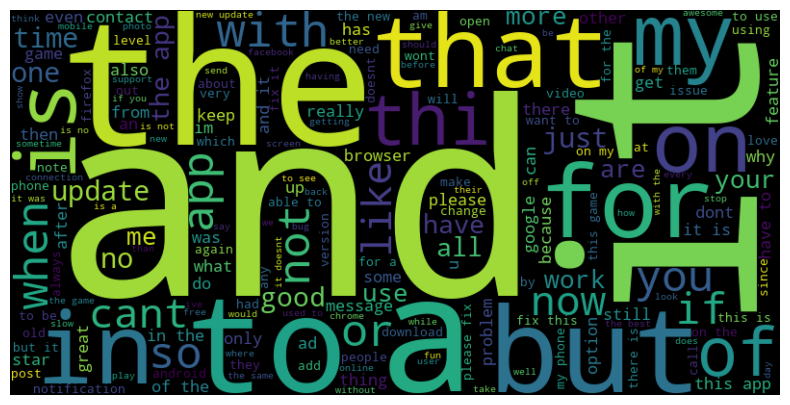

In [34]:
from wordcloud import WordCloud

# Concatenar todas las reseñas en un solo texto
text_all_reviews = " ".join(data["review"])

# Crear y generar la nube de palabras
wordcloud = WordCloud(stopwords="english", width=800, height=400).generate(text_all_reviews)

# Mostrar la imagen de la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Las 10 palabras más frecuentes son:
app: 152
game: 87
great: 84
good: 68
love: 54
like: 53
best: 44
use: 44
browser: 40
really: 39


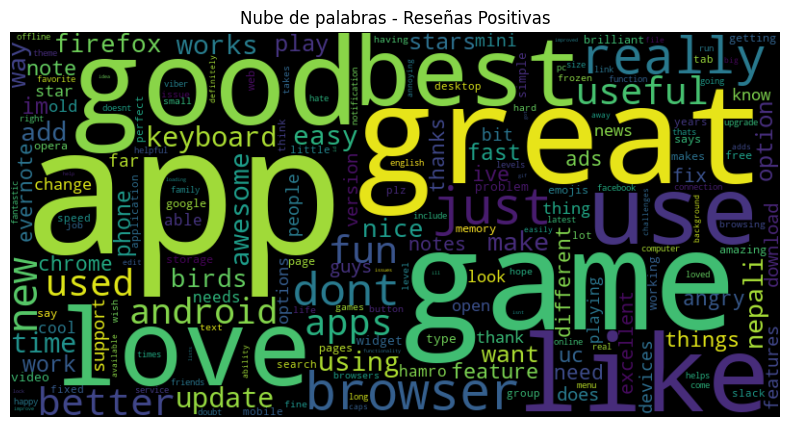

In [35]:
# Filtro de reseñas positivas y negativas
reviews_positive = data[data['polarity'] == 1]['review']
reviews_negative = data[data['polarity'] == 0]['review']

# Crear el CountVectorizer con eliminación de stopwords
vec_model = CountVectorizer(stop_words="english")

# Aplicar el CountVectorizer a las reseñas positivas
X_positive = vec_model.fit_transform(reviews_positive)
positive_words = vec_model.get_feature_names_out()
# Suma las apariciones de cada palabra en todas las reseñas positivas. Convierte el resultado en un array denso de Numpy (matriz en un vector
# que contiene las frecuencias de las palabras). Si es necesario lo convierte en 1D.
positive_freq = np.asarray(X_positive.sum(axis=0)).flatten()

# Diccionario de tuplas (word, freq)
positive_freq_words = dict(zip(positive_words, positive_freq))

# Ordenar las palabras por frecuencia (de mayor a menor)
palabras_frecuentes_ordenadas = sorted(positive_freq_words.items(), key=lambda x: x[1], reverse=True)

# Tomar las 10 palabras más frecuentes
top_palabras = palabras_frecuentes_ordenadas[:10]

# Mostrar las 10 palabras más frecuentes
print("Las 10 palabras más frecuentes son:")
for palabra, frecuencia in top_palabras:
    print(f"{palabra}: {frecuencia}")

# Crear y generar la nube de palabras para reseñas positivas
wordcloud_positive = WordCloud(width=800, height=400, stopwords="english").generate_from_frequencies(positive_freq_words)

# Mostrar la nube de palabras para reseñas positivas
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras - Reseñas Positivas")
plt.show()


Las 10 palabras más frecuentes son:
app: 270
update: 163
fix: 129
new: 112
dont: 102
time: 99
like: 86
use: 85
doesnt: 83
just: 81


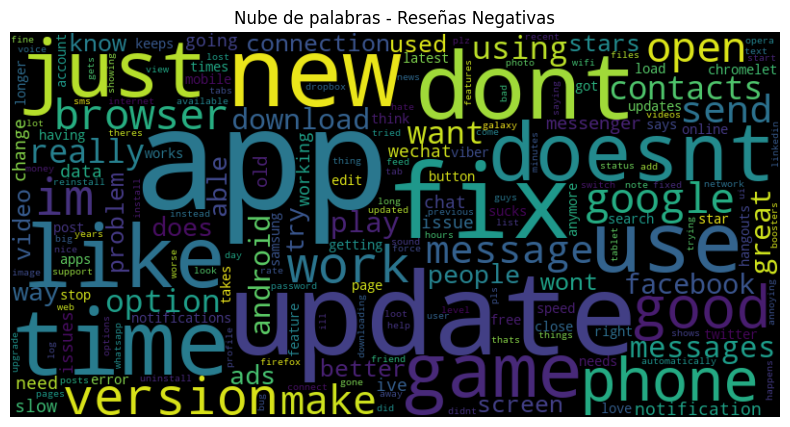

In [36]:
# Aplicar el CountVectorizer a las reseñas positivas
X_positive = vec_model.fit_transform(reviews_negative)
positive_words = vec_model.get_feature_names_out()
# Suma las apariciones de cada palabra en todas las reseñas positivas. Convierte el resultado en un array denso de Numpy (matriz en un vector
# que contiene las frecuencias de las palabras). Si es necesario lo convierte en 1D.
positive_freq = np.asarray(X_positive.sum(axis=0)).flatten()

# Diccionario de tuplas (word, freq)
positive_freq_words = dict(zip(positive_words, positive_freq))

# Ordenar las palabras por frecuencia (de mayor a menor)
palabras_frecuentes_ordenadas = sorted(positive_freq_words.items(), key=lambda x: x[1], reverse=True)

# Tomar las 10 palabras más frecuentes
top_palabras = palabras_frecuentes_ordenadas[:10]

# Mostrar las 10 palabras más frecuentes
print("Las 10 palabras más frecuentes son:")
for palabra, frecuencia in top_palabras:
    print(f"{palabra}: {frecuencia}")

# Crear y generar la nube de palabras para reseñas positivas
wordcloud_positive = WordCloud(width=800, height=400, stopwords="english").generate_from_frequencies(positive_freq_words)

# Mostrar la nube de palabras para reseñas positivas
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras - Reseñas Negativas")
plt.show()